# Support points with Exponential Mechanism

### Procedure:


1. Given data $X = \{x_1, \ldots, x_m\}$ on space $\mathcal{D} \in [0, 1]^d$, find optimal support points $Y = \{y_1, \ldots, y_n\}$.
2. Using energy distance (with Lp norm) as the score function of the exponential mechanism, the sensitivity is $\Delta u = \frac{2 d^{\frac{1}{p}}}{n^2}$. The exponential mechanism samples a new energy value $\tilde{e} \sim \mbox{Lap}(\frac{2S}{\epsilon})$, where $\epsilon$ is the privacy budget.
3. Let $\tilde{Y}$ be a copy of $Y$. While $e(\tilde{Y}, Y) < \tilde{e}$, perturb all points in $\tilde{Y}$ with small step in a random direction.


_____

# 0. Helper Functions

In [1]:
%matplotlib inline

import sys
print(sys.version)
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import os
import pdb
import sys
import time
import tensorflow as tf
print(tf.__version__)

from sp_utils import get_support_points, energy, sample_sp_exp_mech

3.7.1 (default, Nov 28 2018, 11:55:14) 
[Clang 9.0.0 (clang-900.0.39.2)]
1.13.1


____

# 1. Global Config

In [2]:
# Set global constants.          # main1()
IS_TF = True                     # Boolean. Use TensorFlow rather than analytical gradients.
Y_INIT_OPTION = 'radial'         # ['grid', 'random', 'radial']
DATA_SOURCE = 'balog'            # ['balog', 'gaussian', 'gamma', 'beta']
MAX_ITER = 301                   # Num iterations in each support point optimization. [301]
LR = 0.01                        # Energy optimization learning rate. [1e-2]

ENERGY_POWER = 2.                # Power for energy distance kernel.
ALPHA = 1                        # Differential privacy level.
M = 200                          # Number of data points.
N = 20                           # Number of support points.
DIM = 2                          # Dimension of data.
STEP_SIZE = 5e-4                 # Diffusion and MH step sizes.
NUM_Y_TILDES = 500               # Number of samples of support points.

___

# 2. Load and Plot Data

In [3]:
if DATA_SOURCE == 'balog':
    os.system('python data.py {} {}'.format(M, DIM))
    
    # Note that Balog's N is our M.
    DATA_PATH = '../data/mixture_of_Gaussians_N{}_D{}.npz'. format(M, DIM)

Loaded M=200 data points with dimension DIM=2


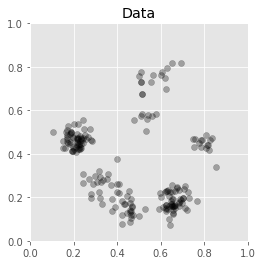

In [4]:
# Load data.
if DATA_SOURCE == 'balog':
    data = np.load(DATA_PATH)
    x = data['X_private']
    assert (M, DIM) == np.shape(x), 'Balog data dims do not match global params.'
    print('Loaded M={} data points with dimension DIM={}'.format(M, DIM))
    plt.scatter(x[:,0], x[:,1], c="black", alpha=0.3);
    plt.title('Data');
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

___

# 3. Run Support Point Optimization


  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Overall it/s: 0.0107


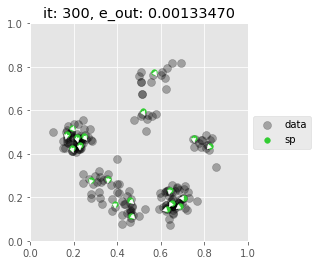

In [5]:
# Compute m support points on full set.
y_opt, e_opt = get_support_points(x, N, MAX_ITER, LR, is_tf=IS_TF)

___

# 4. Define sensitivity.

In [6]:
# Define energy sensitivity for Exponential Mechanism.
energy_sensitivity = 2 * DIM ** (1. / ENERGY_POWER) / N ** 2
print(('Laplace(2 * U / alpha) = Laplace(2 * {:.4f} / {:.2f}) '
       '= Laplace({:.3f})').format(energy_sensitivity, ALPHA, 
                                   2. * energy_sensitivity / ALPHA))

Laplace(2 * U / alpha) = Laplace(2 * 0.0071 / 1.00) = Laplace(0.014)


___

# 5. Sample support points.



--------- RUNNING DIFFUSION ----------

Diffusion count     2, e_opt:  0.001335, e~: 0.002120, energy(y,y~): 0.002712, error%: 0.279482


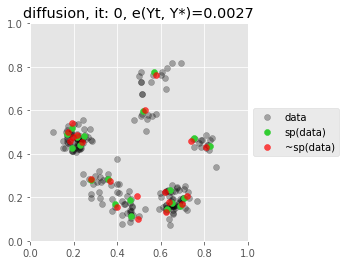

In [7]:
# Sampling parameters.
STEP_SIZE = 1e-2
NUM_Y_TILDES = 1
# ALPHA = 1.

RUN_MH = 0
RUN_DIFFUSION = 1


if RUN_MH:
    METHOD = 'mh'
    print('\n\n--------- RUNNING {} ----------\n'.format(METHOD.upper()))
    (y_tildes_mh,
     energies_mh) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                                       METHOD, STEP_SIZE, NUM_Y_TILDES, 
                                       alpha=ALPHA)

if RUN_DIFFUSION:
    METHOD = 'diffusion'
    print('\n\n--------- RUNNING {} ----------\n'.format(METHOD.upper()))
    (y_tildes_diffusion,
     energies_diffusion) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                                              METHOD, STEP_SIZE, NUM_Y_TILDES,
                                              alpha=ALPHA)

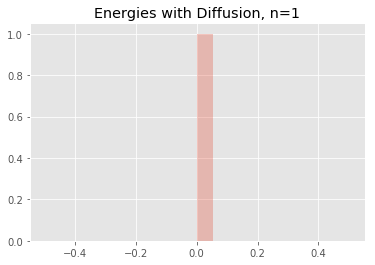

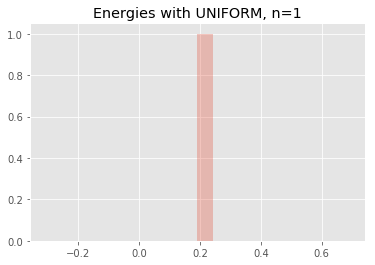

In [8]:
# Plot results.
if RUN_MH:
    plt.title('Energies with MH, n={}'.format(len(energies_mh)))
    plt.hist(energies_mh, bins=20, alpha=0.3)
    plt.show()

if RUN_DIFFUSION:
    plt.title('Energies with Diffusion, n={}'.format(len(energies_diffusion)))
    plt.hist(energies_diffusion, bins=20, alpha=0.3)
    plt.show()

# Compare to energies of e(y_opt, uniform)
baseline_energies = np.zeros(NUM_Y_TILDES)
for i in range(NUM_Y_TILDES):
    e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))
    baseline_energies[i] = e_
plt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))
plt.hist(baseline_energies, bins=20, alpha=0.3)
plt.show()

___

# 6. Expand to full data set.

Diffusion count    37, e_opt:  0.001335, e~: 0.009011, energy(y,y~): 0.009016, error%: 0.000546


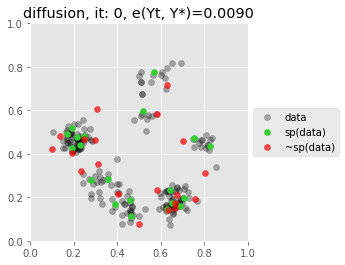

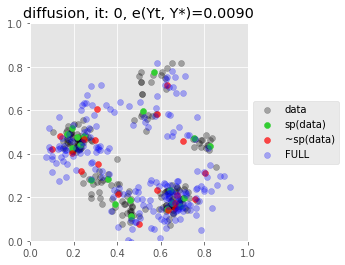

In [27]:
# Show data and y_tilde.
STEP_SIZE = 1e-2
NUM_Y_TILDES = 1
ALPHA = 1.
METHOD = 'diffusion'
BANDWIDTH = 0.06
SAMPLE_SIZE = M

ys, es = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                            METHOD, STEP_SIZE, NUM_Y_TILDES, alpha=ALPHA)
y_tilde = ys[0]
energy_y_y_tilde = es[0]

# Sample from mixture model centered on noisy support points.
choices = np.random.choice(range(len(y_tilde)), size=SAMPLE_SIZE)
full_sample = (
    y_tilde[choices] + np.random.normal(0, BANDWIDTH, size=(SAMPLE_SIZE, 2)))

plt.scatter(x[:, 0], x[:, 1], c='black', alpha=0.3, label='data')
plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', label='sp(data)')
plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
plt.scatter(full_sample[:, 0], full_sample[:, 1], c='blue', alpha=0.3, label='FULL')

plt.title('{}, it: {}, e(Yt, Y*)={:.4f}'.format(METHOD, i, energy_y_y_tilde))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


# End.